# Neuromodulator Imaging Analysis

Here's some instructions from Alex on Friday 15/09:

- Simulate a train of APs of neurons: assuming a spike every second, then scale it to faster, then addd jitter/Poisson distribution — try drawing from an exp distribution or flip a coin each time
- Simulate relationship btn APs and DA release
- Simulate the signal delta F/ F

In this notebook, we will simulate the dynamics of neuromodulator concentration. For this we will start with:
- Simulation of a firing neuron, 
- Translate that to release of a neuromodulator. 
- Followed by a simulation of the signal $\Delta F/F$ produced by the changes in neuromodulator concentration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

### Simulation of firing neuron

Here, we define a function that simulates the activity of one neuron and takes the number of timesteps of activity as an argument.

In [2]:
# define function that simulates a firing neuron

# it takes the number of timesteps as the argument
def simulate_neuron(n_timesteps):
    
    # Start with an array of the timesteps that we're recording from
    firing_neuron = np.zeros(n_timesteps)

    # Then populate the array with signals - firing & not firing -- with a specific probability that you choose
    for i in range(n_timesteps):
        x = np.random.rand()

        # firing with probability of 1/1000 at each time bin
        if x < 0.001:
            firing_neuron[i]=1

    # then make a plot of it!
    plt.plot(firing_neuron)
    plt.xlabel('timesteps')
    plt.ylabel('Neuron activity')
    plt.title('Neuron Activity over {} timesteps'.format(n_timesteps))
    plt.show()
  

    return firing_neuron



Now let's visualize our firing neuron to see if we simulated it correctly

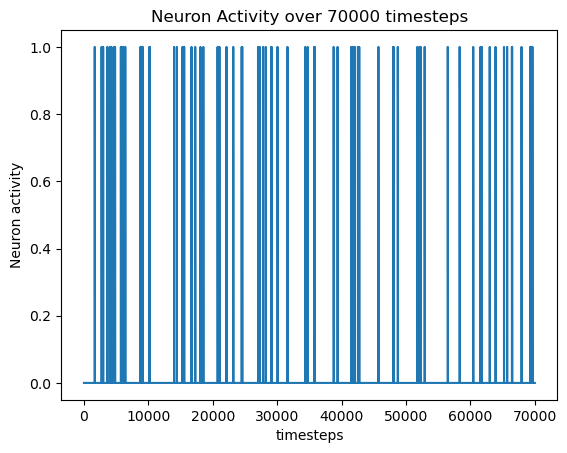

In [3]:
# define the number of timesteps 70 seconds - 70000 milliseconds
# each timestep / bin is 1 ms wide

firing_neuron = simulate_neuron(70000)

Ok, look's like the neuron is firing as we expect it to over 70,000 timesteps


Below is an alternative approach to generating the spiking activity of a neuron, that makes use of the signal.unit_impulse feature of scipy.

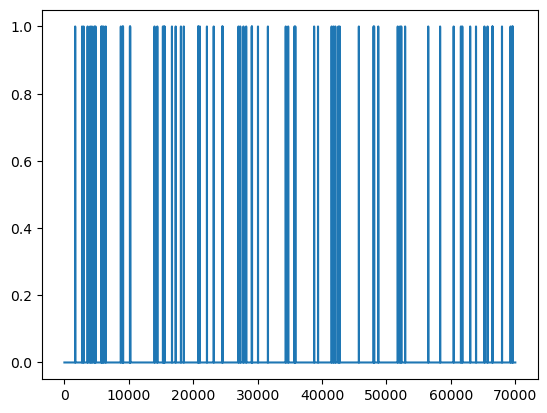

In [5]:
# timesteps where the neuron fired
firing_timesteps = np.nonzero(firing_neuron)

# generate visual representation of a train of spikes / I'll use this as the first approx. for the changes in [NM]
# ideally for the changes in [NM], we'd like to produce a chain of decaying exponents -- hopefully we produce them in a later cell

n_timesteps =70000
spike_train = sp.signal.unit_impulse(n_timesteps,idx=firing_timesteps)

plt.plot(spike_train)

### Neuromodulator concentration

Now let's simulate a simple case of neuromodulator release caused by our firing neuron. Here, we assume that the neuromodulator release occurs instantaneously, and that we are dealing with one compartment and there's no uptake. 

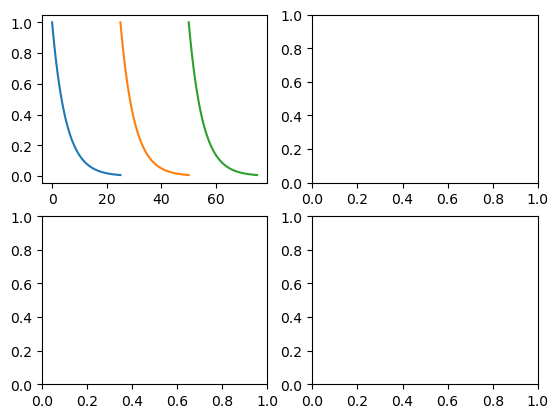

In [6]:
# The logic: each time the neuron fires, a spike appears this is followed by an explonential decay
# try to plot a series of exponentials

fig, ax = plt.subplots(2,2)

z = np.arange(100)
z1 = np.linspace(0,25)
z2 = np.linspace(25,50)
z3 = np.linspace(50,75)
tau_prime = 5
ax[0,0].plot(z1,np.exp(-z1/tau_prime))
ax[0,0].plot(z2,np.exp(-(z1)/tau_prime))
ax[0,0].plot(z3,np.exp(-(z1)/tau_prime))

Ok, so the above simple simulation of the chain of transients didn't work too well. Let's try a different approach


 Below is plot of the equation 7 in \cite{}, describing classic dynamics of calcium:
 
\Delta [Ca^{2+}](n \Delta t) = A \Sum_{i=1}^n \exp^{-(i\Delta t)/\tau} = A (\Sum^n_{i=1}(\exp^{-\Delta t/\tau})^i - 1) = \frac{A}{(\exp^{\Delta t/\tau} - 1)} (1 - \exp^{-n \Delta t /\tau}) 

This equation shows the [Ca^{2+}]_i level above resting immediately before the (n+1)-th action potential.

We are going to assume that the dynamics governing the NM is the same, so to get [NM], we will replace [Ca^{2+}] with it. 



Text(0.5, 1.0, 'NM transients caused by neuron firing')

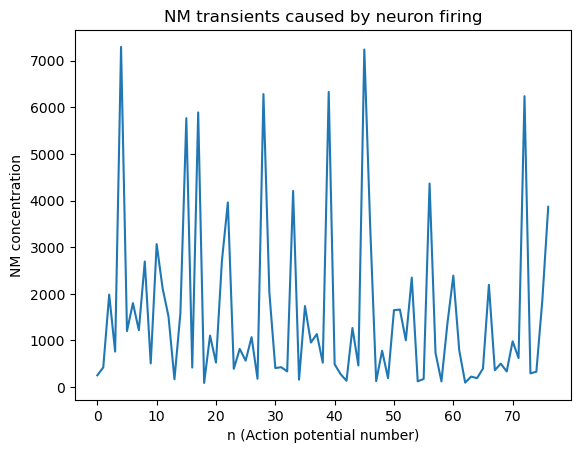

In [7]:
# attempt at simulation of the ca transients in eq. 7 of 
# calcium dynamics paper


# the time between the start and the first action potential
dt_0 = np.array([firing_timesteps[0][0]]) # i know it's weird, it looks like an array of arrays

# array of the intervals between the firing timesteps
dt_sequence = np.diff(firing_timesteps)

# Include the time interval for the 1st action potential
dt_sequence = np.concatenate((dt_0,dt_sequence.flatten()), axis=0)

# length of dt_seq == 77
length_dt = np.size(firing_timesteps)

# generate seqauence of numbers to use in plot to compare the different transients
n_spikes = np.size(firing_timesteps)
z4 = np.linspace(0,n_spikes-1,n_spikes)

# convert dt to seconds so that we don't get infinities
dt_sequence_s = dt_sequence/1000

# constants to plug into the equation from the paper
tau = 5
A = 100
n = length_dt

# [NM] transients caused by the neuron firing
transients = (A/(np.exp(dt_sequence_s / tau) - 1)) * (1 - np.exp(-n*dt_sequence_s / tau))


#plot it
plt.plot(z4,transients)
plt.xlabel('n (Action potential number)')
plt.ylabel('NM concentration')
plt.title('NM transients caused by neuron firing')

The above plot also enables easy comparison of the different spikes' magnitude

In [11]:
np.size(firing_timesteps)

78

Below, we make a function to simulate the changes in neuromodulator concentration, [NM], caused by the firing neuron. These transients are calculated based on an equation modelling calcium dynamics. --- CITE THIS PAPER

Text(0.5, 1.0, 'NM concentration across all timesteps')

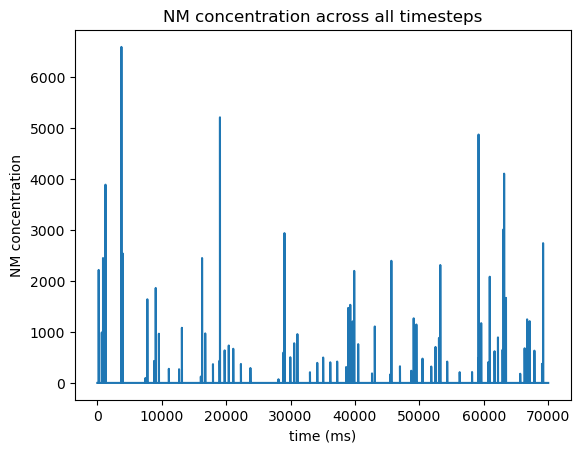

In [16]:
# make an array with the [NM] at all the timesteps not just at the spike times
nm_conc = firing_neuron
nm_conc[firing_timesteps] = transients

# plot this at all timesteps
t = np.linspace(0,n_timesteps-1,n_timesteps)

plt.plot(t,nm_conc)
plt.xlabel('time (ms)')
plt.ylabel('NM concentration')
plt.title('NM concentration across all timesteps')



Now, let's simulate the flourescence signal produced by the changes in the neuromodulator concentration,[NM]. This is described by eq. 3 in the calcium dynamics paper earlier mentioned: ** insert equation here

Text(0.5, 1.0, 'Flourescence intensity signal over time')

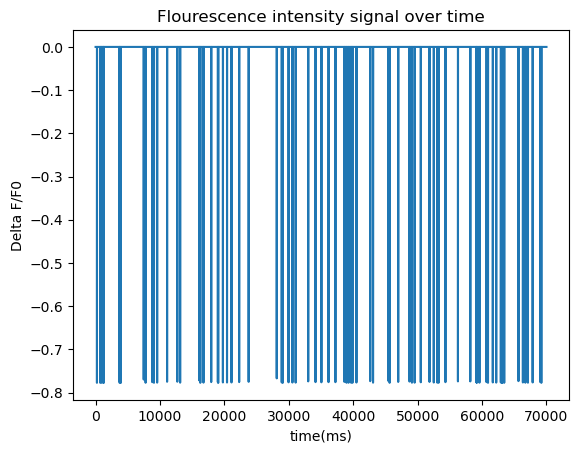

In [18]:
# Define the constants used in the equation:
# GET ACTUAL VALUES FROM KENTA

# the dissociation constant for the NM binding to the sensor
K_D = 1 

# The fluorescence when sensor is completely unbound to NM
F_max = 45

# The fluorescence when sensor is completely bound to NM
F_min = 10

# define K_D prime as
K_Dp = K_D*(F_max/F_min)

# the initial/steady state concentration, [NM]i,0, of the neuromdultor
# CONFIRM VALUE FROM KENTA
nm_conc_io = 0 


# define the numerator and denominator
numerator = (K_Dp + nm_conc)/(K_D + nm_conc)
denominator = (K_Dp + nm_conc_io)/(K_D + nm_conc_io)

# derive delta f/f0 by plugging in
delta_f_f0 = (numerator/denominator) - 1

# plot the normalized signal delta f/f0 at the different t
plt.plot(t,delta_f_f0)
plt.xlabel('time(ms)')
plt.ylabel('Delta F/F0')
plt.title('Flourescence intensity signal over time')





